In [24]:
import os
import pandas as pd

results_path = "./hyperparameter_analysis/"

In [25]:
import matplotlib
!pip install matplotlib --upgrade
matplotlib.__version__

Requirement already up-to-date: matplotlib in /home/mcse/.local/lib/python3.8/site-packages (3.6.2)


'3.6.2'

In [44]:
def csv_to_dataframe_to_ranked_results(results_file):
  #
  results = pd.read_csv(os.path.join(results_path, results_file))
  results["name"] = results.apply(lambda row: str(int(row["name"])).zfill(7), axis=1)
  ranks = results.drop("name", axis=1).rank(ascending=False).add_suffix("_rank")
  ranked_results = pd.concat([results, ranks], axis=1)
  metrics_to_eval = ["botwiki-verified_rank", "midterm-18_rank", "gilani-17_rank", "cresci-rtbust_rank", "5-fold_cross-validation_rank", "spearman_r_rank"]
  rank_product = ranked_results[metrics_to_eval].product(axis=1)
  ranked_results["rank"] = rank_product.rank(ascending=True)
  return ranked_results




In [45]:
def ranked_comparison(ranked_results, ranked_results2):
  metrics_to_subtract = ["rank"]
  sub_abs = ranked_results[metrics_to_subtract].subtract(ranked_results2[metrics_to_subtract], axis=1).abs()
  average_change = sub_abs.sum().div(119).round()

  print(average_change)

In [46]:
def performance_eval(ranked_results):
  metrics_to_average = ["botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust", "5-fold_cross-validation", "spearman_r"]
  average = ranked_results[metrics_to_average].sum().div(119)
  sum_div_average = average.sum()/len(metrics_to_average)
  sum_div_average = sum_div_average.round(decimals=6)

  print(sum_div_average)

  return sum_div_average

In [47]:
def performance_eval_top_n(ranked_results, n):
  metrics_to_average = ["botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust", "5-fold_cross-validation", "spearman_r"]
  top_results = ranked_results.sort_values("rank").head(n)
  average = top_results[metrics_to_average].sum().div(n)
  sum_div_average = average.sum()/len(metrics_to_average)
  sum_div_average = sum_div_average.round(decimals=6)

  print(sum_div_average)

  return sum_div_average

In [48]:
#Most of the work is actually done, but in this cell, there will be a function which can take two sets of results with different hyperparameters.
def comparison(hyper, hyper2, n):
  ranked_res = csv_to_dataframe_to_ranked_results(hyper)
  ranked_res2 = csv_to_dataframe_to_ranked_results(hyper2)
  ranked_comparison(ranked_res, ranked_res2)
  print("performance of " + hyper)
  performance_eval(ranked_res)
  print("performance of " + hyper2)
  performance_eval(ranked_res2)
  print(hyper + " vs. " + hyper2)
  performance_eval_top_n(ranked_res,n)
  performance_eval_top_n(ranked_res2,n)  

In [49]:
n = 30
comparison("mean.csv", "results_m_d_2.csv", n)

rank    32.0
dtype: float64
performance of mean.csv
0.784831
performance of results_m_d_2.csv
0.747735
mean.csv vs. results_m_d_2.csv
0.81382
0.765918


In [34]:
def top_n_models(ranked_results, n):
  top_results = ranked_results.sort_values("rank").head(n).set_index("name").transpose()
  top_results = top_results.round(decimals=2)
  top_results = top_results.drop(labels=top_results.columns[7:],axis=1)
  #sort_values("rank").

  top_results_file = os.path.join(results_path, "top_mean_results.csv")
  top_results.to_csv(top_results_file)

  top_results

In [22]:
def top_model(hyper, n):
  ranked_res = csv_to_dataframe_to_ranked_results(hyper)
  top_n_models(ranked_res, n)

In [35]:
top_model("mean.csv", 30)

In [53]:
result_files = ["mean.csv", "results_c_w_bal.csv", "results_m_d_128.csv", "results_m_d_2.csv", "results_crit_ent.csv", "results_w_s_true.csv"]

overall_score = []
top_n_score = []

for file in result_files:
    overall_score.append(performance_eval(csv_to_dataframe_to_ranked_results(file)).round(4))
    top_n_score.append(performance_eval_top_n(csv_to_dataframe_to_ranked_results(file), 30).round(4))


0.784831
0.81382
0.781912
0.814361
0.782813
0.805458
0.747735
0.765918
0.778707
0.80545
0.782033
0.80669


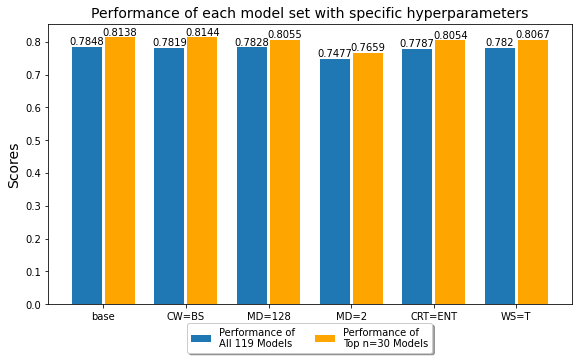

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

labels = ['base', 'CW=BS','MD=128', 'MD=2', 'CRT=ENT', 'WS=T']
labels = [ '\n'.join(wrap(l, 8)) for l in labels ]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2.0, overall_score, width/1.1, label='Performance of\nAll 119 Models')
rects2 = ax.bar(x + width/2.0, top_n_score, width/1.1, label='Performance of\nTop n=30 Models', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Performance of each model set with specific hyperparameters', fontsize=14)
ax.set_xticks(x, labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)

fig.tight_layout()
fig.set_size_inches(8.5, 5.5)

plt.savefig("test.svg")
plt.show()